In [9]:
# Install necessary library if you haven't already
# !pip install pandas numpy tsaug

import pandas as pd
import numpy as np
import tsaug # Import the time series augmentation library
import os

In [10]:
# --- Configuration ---
# Updated input path using raw string for Windows compatibility
INPUT_CSV_PATH = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_350\input_2D\keypoints.csv"
# Updated output path using raw string for Windows compatibility
OUTPUT_DIR = r"D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated"
NUM_SYNTHETIC_SAMPLES = 10 # How many synthetic samples to generate
SEED = 42 # For reproducibility

# --- Augmentation Parameters (CRITICAL: Tune these based on the new data's scale) ---
# Jittering adds random noise. Scale controls the standard deviation of the noise.
# If your new data has values around 1.0, a JITTER_SCALE of 0.02 might be appropriate.
# If your new data has much smaller values (e.g., 0.01), JITTER_SCALE might need to be smaller (e.g., 0.0002).
JITTER_SCALE = 0.02

# Time warping stretches/compresses time segments.
TIME_WARP_N_SPEED_CHANGE = 5

print("Configuration set.")
print(f"Input Path: {INPUT_CSV_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Number of Samples to Generate: {NUM_SYNTHETIC_SAMPLES}")
print(f"JITTER_SCALE (initial): {JITTER_SCALE}")
print("IMPORTANT: Review JITTER_SCALE after checking the loaded data's statistics in the next cell.")

Configuration set.
Input Path: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_350\input_2D\keypoints.csv
Output Directory: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated
Number of Samples to Generate: 10
JITTER_SCALE (initial): 0.02
IMPORTANT: Review JITTER_SCALE after checking the loaded data's statistics in the next cell.


In [11]:
# --- Load Original Data ---
print(f"Loading original data from: {INPUT_CSV_PATH}")
try:
    # Read the CSV, assuming no header as per the file structure
    original_df = pd.read_csv(INPUT_CSV_PATH, header=None)
    # Convert to NumPy array for tsaug
    original_sequence = original_df.to_numpy()
    print(f"Original data shape: {original_sequence.shape}")

    # --- Inspect the scale of the loaded data ---
    print("\n--- Data Statistics (First 5 columns) ---")
    print(original_df.iloc[:, :5].describe())
    print("\nIMPORTANT: Based on these statistics (especially mean, min, max),")
    print("you might need to adjust JITTER_SCALE and other augmentation parameters in Cell 2.")
    print("If values are very small (e.g., close to 0 or 1), a JITTER_SCALE of 0.02 might be too large.")
    print("If values are in the hundreds, 0.02 might be appropriate or even need to be larger for visible effect.")

except FileNotFoundError:
    print(f"Error: Input file not found at {INPUT_CSV_PATH}")
    raise FileNotFoundError(f"Input file not found at {INPUT_CSV_PATH}")
except Exception as e:
    print(f"Error reading CSV file: {e}")
    raise e

Loading original data from: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_2D3D_skeletons_coarsened\Turning_coarsen_CSV\Pt204_C_n_350\input_2D\keypoints.csv
Original data shape: (91, 34)

--- Data Statistics (First 5 columns) ---
                0           1           2           3           4
count   91.000000   91.000000   91.000000   91.000000   91.000000
mean   115.340659  189.120879  117.428571  188.879121  117.230769
std     10.909954    5.843962   13.841277    4.591865    9.860220
min    102.000000  182.000000   98.000000  182.000000  104.000000
25%    106.000000  184.000000  102.000000  186.000000  106.000000
50%    108.000000  186.000000  116.000000  188.000000  120.000000
75%    128.000000  193.000000  131.000000  191.000000  126.000000
max    132.000000  202.000000  136.000000  200.000000  132.000000

IMPORTANT: Based on these statistics (especially mean, min, max),
you might need to adjust JITTER_SCALE and other augmentation parameters in Cell 2.
If

In [12]:
# --- Prepare Data for tsaug ---
# tsaug often expects data in shape (N, T, C) = (Num Sequences, Num Timesteps, Num Channels/Features)
# Reshape our single sequence (T, C) into (1, T, C)

if 'original_sequence' in locals(): # Check if data loaded successfully
    num_frames = original_sequence.shape[0]
    num_features = original_sequence.shape[1]
    data_for_aug = original_sequence.reshape(1, num_frames, num_features)
    print(f"Reshaped data for augmentation: {data_for_aug.shape}")
else:
    print("Error: Original data not loaded. Cannot proceed.")

Reshaped data for augmentation: (1, 91, 34)


In [13]:
# --- Define Augmenter Pipeline ---
# Combine multiple augmentation techniques sequentially using '+'.
# '+' runs augmenters in sequence deterministically (all applied).
# Removed tsaug.Scale as it caused an AttributeError.

try:
    augmenter = (
        tsaug.AddNoise(scale=JITTER_SCALE, seed=SEED) + # Apply jittering
        tsaug.TimeWarp(n_speed_change=TIME_WARP_N_SPEED_CHANGE, seed=SEED + 1) # Apply time warping
        # Add other *valid* tsaug augmenters here if desired using '+', e.g.:
        # + tsaug.Quantize(n_levels=20)
        # + tsaug.Drift(max_drift=0.1, n_drift_points=3)
        # + tsaug.Reverse()
    )
    print("\nAugmenter pipeline defined:")
    print(augmenter)
except TypeError as e:
    print(f"\nTypeError defining augmenter pipeline: {e}")
    print("There might be an issue with the tsaug installation or parameter types.")
except AttributeError as e:
     print(f"\nAttributeError defining augmenter pipeline: {e}")
     print("A specified augmenter might not exist in your tsaug version.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


Augmenter pipeline defined:


In [14]:
# --- Generate and Save Synthetic Samples ---

if 'data_for_aug' in locals() and 'augmenter' in locals(): # Check if prerequisites are met
    print(f"\nGenerating {NUM_SYNTHETIC_SAMPLES} synthetic samples...")

    # Create the output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Saving synthetic data to: {OUTPUT_DIR}")

    for i in range(NUM_SYNTHETIC_SAMPLES):
        # Apply the augmentation pipeline to the original data
        # augmenter.augment returns shape (N, T, C), so we take the first element [0]
        synthetic_sequence = augmenter.augment(data_for_aug)[0]

        # Define the output filename
        # Extract original filename base to include in the synthetic filename for clarity
        original_filename_base = os.path.splitext(os.path.basename(INPUT_CSV_PATH))[0]
        output_filename = os.path.join(OUTPUT_DIR, f"{original_filename_base}_synthetic_{i+1:03d}.csv")

        # Save the synthetic sequence as a CSV file (without header/index)
        synthetic_df = pd.DataFrame(synthetic_sequence)
        try:
            synthetic_df.to_csv(output_filename, header=False, index=False)
            print(f"  Saved: {output_filename} (Shape: {synthetic_sequence.shape})")
        except Exception as e:
            print(f"  Error saving {output_filename}: {e}")

    print("\nSynthetic data generation complete.")
else:
    print("Error: Cannot generate data. Check previous cells for errors (e.g., data loading or augmenter definition).")


Generating 10 synthetic samples...
Saving synthetic data to: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_001.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_002.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_003.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_004.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_005.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30v9cl2fapjggz4q1x7\Turning\Data\turning_generated\keypoints_synthetic_006.csv (Shape: (91, 34))
  Saved: D:\Courses\thesis\data\21h9f9e30


Plotting original vs. 3 individual synthetic samples...


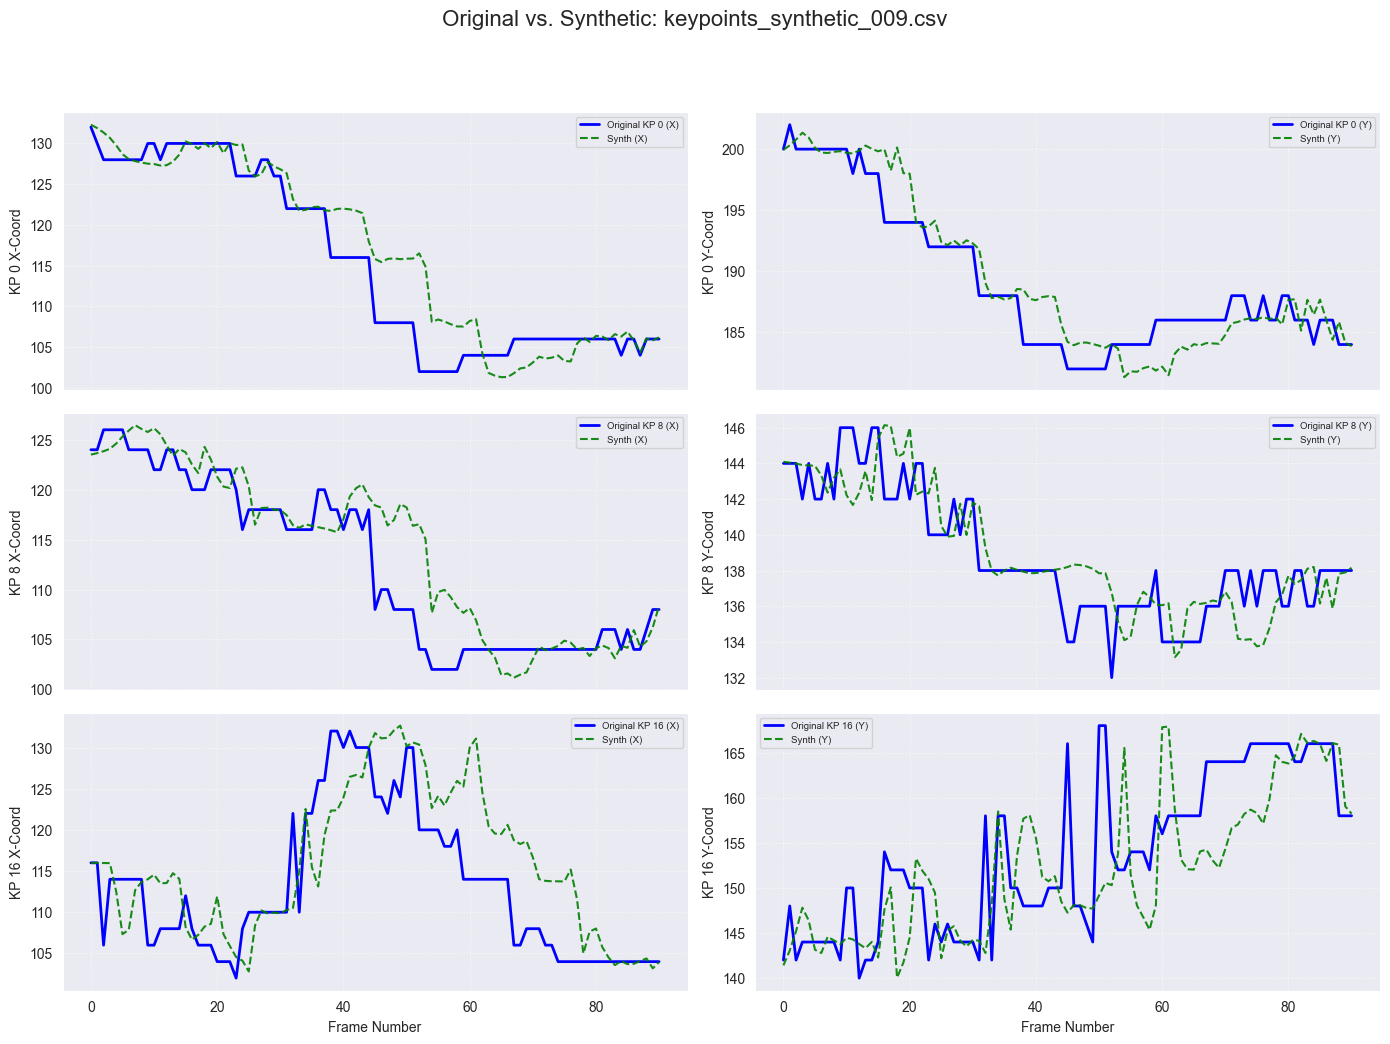

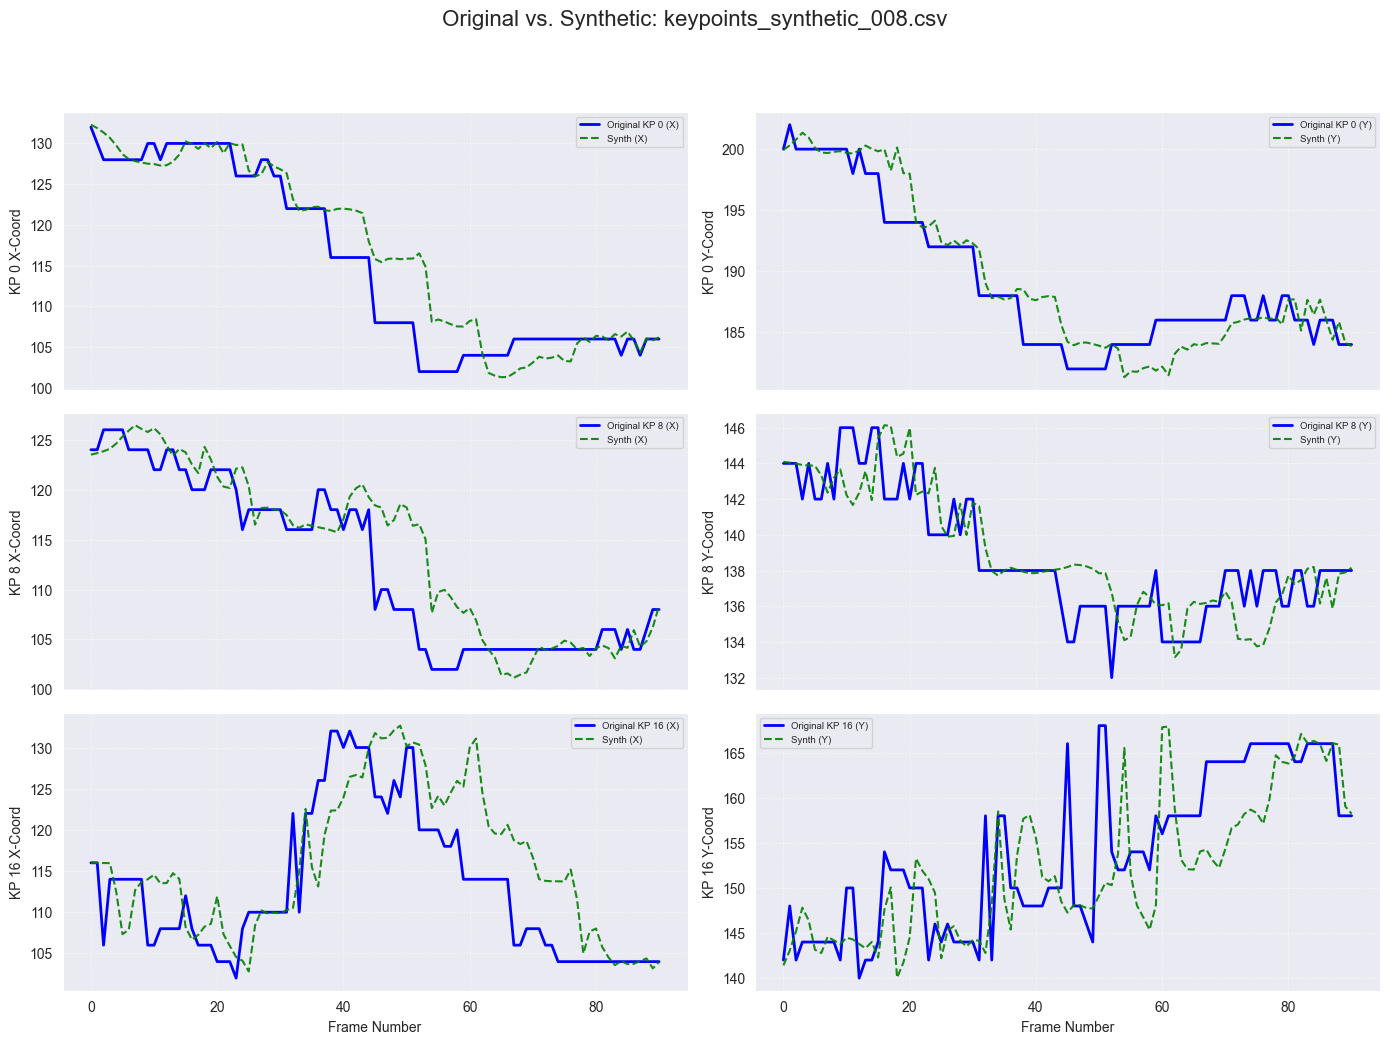

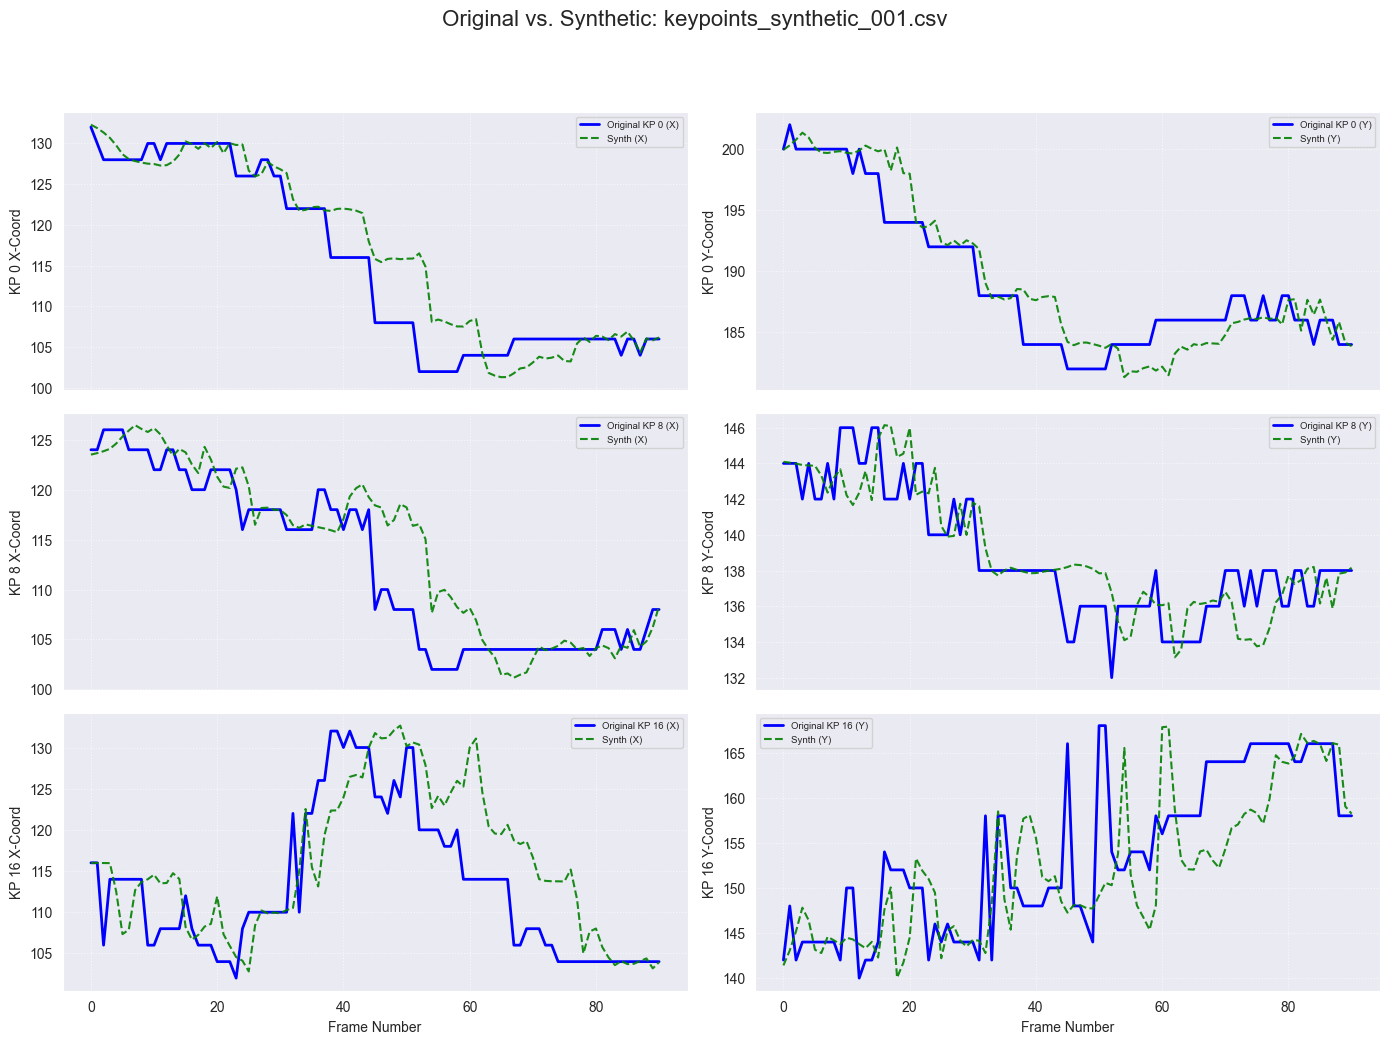


Plotting complete.
If synthetic lines are still very similar to original, consider increasing augmentation strengths (e.g., JITTER_SCALE) in Cell 2.


In [17]:
import matplotlib.pyplot as plt
import random
import numpy as np # Ensure numpy is imported if not already
import pandas as pd # Ensure pandas is imported if not already
import os # Ensure os is imported

# --- Configuration for Plotting ---
# Select a few keypoints to plot (indices based on 0 to 16 for 17 keypoints)
keypoint_indices_to_plot = [0, 8, 16] # Example: Nose (0), MidHip (8 if it exists), Right Ankle (16)
num_synthetic_to_plot = 3 # How many synthetic samples to plot (will create this many separate figures/plot sets)

# Define plot styles
original_color = 'blue'
synthetic_color = 'green'
original_linewidth = 2
synthetic_linestyle = '--'

# --- Load synthetic samples for comparison ---
if 'OUTPUT_DIR' in locals() and 'INPUT_CSV_PATH' in locals():
    original_base_for_filter = os.path.splitext(os.path.basename(INPUT_CSV_PATH))[0]
    synthetic_files = [
        os.path.join(OUTPUT_DIR, f)
        for f in os.listdir(OUTPUT_DIR)
        if f.endswith('.csv') and f.startswith(original_base_for_filter) # Filter for related synthetic files
    ]

    if not synthetic_files:
        print("No synthetic files found in the output directory for the current input file. Run Cell 6 first.")
    else:
        # Select random synthetic samples to plot, or plot all up to num_synthetic_to_plot
        samples_to_plot_paths = random.sample(synthetic_files, min(num_synthetic_to_plot, len(synthetic_files)))

        if 'original_sequence' not in locals():
            print("Original sequence not loaded. Please run Cell 3.")
        else:
            num_frames_original = original_sequence.shape[0]
            time_steps_original = np.arange(num_frames_original)

            print(f"\nPlotting original vs. {len(samples_to_plot_paths)} individual synthetic samples...")

            for sample_idx, file_path in enumerate(samples_to_plot_paths):
                try:
                    df_synth = pd.read_csv(file_path, header=None)
                    synth_seq = df_synth.to_numpy()
                    loaded_sample_name = os.path.basename(file_path)
                except Exception as e:
                    print(f"Error reading synthetic file {file_path}: {e}")
                    continue

                # Create a new figure for each original vs. synthetic comparison
                num_keypoints_to_display = len(keypoint_indices_to_plot)
                fig, axes = plt.subplots(num_keypoints_to_display, 2,
                                         figsize=(14, 3.5 * num_keypoints_to_display),
                                         sharex=True)
                if num_keypoints_to_display == 1: # Adjust axes array if only one keypoint is plotted
                    axes = np.array([axes])

                fig.suptitle(f'Original vs. Synthetic: {loaded_sample_name}', fontsize=16, y=1.02) # Adjust y for title

                for i, kp_index in enumerate(keypoint_indices_to_plot):
                    x_col_index = kp_index * 2
                    y_col_index = kp_index * 2 + 1

                    if x_col_index >= original_sequence.shape[1] or y_col_index >= original_sequence.shape[1]:
                        print(f"Warning: Keypoint index {kp_index} is out of bounds for original data. Skipping.")
                        if axes.ndim > 1 : axes[i,0].set_visible(False); axes[i,1].set_visible(False) # Hide unused subplot
                        else: axes[0].set_visible(False); axes[1].set_visible(False)
                        continue
                    if x_col_index >= synth_seq.shape[1] or y_col_index >= synth_seq.shape[1]:
                        print(f"Warning: Keypoint index {kp_index} is out of bounds for synthetic data {loaded_sample_name}. Skipping.")
                        if axes.ndim > 1 : axes[i,0].set_visible(False); axes[i,1].set_visible(False)
                        else: axes[0].set_visible(False); axes[1].set_visible(False)
                        continue

                    # Plot Original Data
                    axes[i, 0].plot(time_steps_original, original_sequence[:, x_col_index],
                                    label=f'Original KP {kp_index} (X)', color=original_color, linewidth=original_linewidth)
                    axes[i, 1].plot(time_steps_original, original_sequence[:, y_col_index],
                                    label=f'Original KP {kp_index} (Y)', color=original_color, linewidth=original_linewidth)

                    # Plot Current Synthetic Sample
                    synth_frames = synth_seq.shape[0]
                    synth_time_steps = np.arange(synth_frames)
                    axes[i, 0].plot(synth_time_steps, synth_seq[:, x_col_index],
                                    label=f'Synth (X)', linestyle=synthetic_linestyle, color=synthetic_color, alpha=0.9)
                    axes[i, 1].plot(synth_time_steps, synth_seq[:, y_col_index],
                                    label=f'Synth (Y)', linestyle=synthetic_linestyle, color=synthetic_color, alpha=0.9)

                    axes[i, 0].set_ylabel(f'KP {kp_index} X-Coord')
                    axes[i, 1].set_ylabel(f'KP {kp_index} Y-Coord')
                    axes[i, 0].legend(loc='best', fontsize='x-small')
                    axes[i, 1].legend(loc='best', fontsize='x-small')
                    axes[i, 0].grid(True, linestyle=':', alpha=0.7)
                    axes[i, 1].grid(True, linestyle=':', alpha=0.7)

                if num_keypoints_to_display > 0 : # Only set xlabel if plots were made
                    axes[-1, 0].set_xlabel('Frame Number')
                    axes[-1, 1].set_xlabel('Frame Number')

                plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout
                plt.show() # Show the figure for the current synthetic sample

            print("\nPlotting complete.")
            print("If synthetic lines are still very similar to original, consider increasing augmentation strengths (e.g., JITTER_SCALE) in Cell 2.")
else:
    print("Error: OUTPUT_DIR or INPUT_CSV_PATH not defined. Run Cell 2.")


Calculating DTW distance between original and synthetic samples (feature-wise)...

--- DTW Evaluation Summary (Average across features) ---
Number of synthetic samples compared: 10
Average of (Mean Feature-wise DTW Distances): 8.48
Std Dev of (Mean Feature-wise DTW Distances): 0.00
Min (Mean Feature-wise DTW Distance):     8.48
Max (Mean Feature-wise DTW Distance):     8.48
Lower values indicate higher similarity to the original sequence pattern.


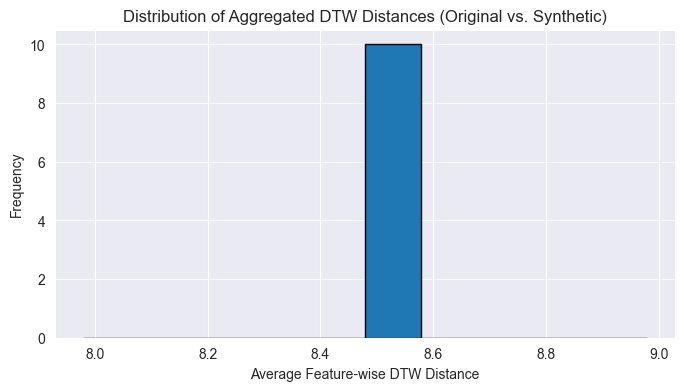

In [16]:
# Install necessary library if you haven't already
# !pip install dtaidistance

from dtaidistance import dtw
import numpy as np
import pandas as pd
import os
import statistics # For mean and stdev
import matplotlib.pyplot as plt

# --- Calculate DTW Distances ---
# This list will store the *average* DTW distance for each synthetic sample
aggregated_dtw_distances = []

if 'OUTPUT_DIR' in locals() and 'INPUT_CSV_PATH' in locals():
    original_base_for_filter = os.path.splitext(os.path.basename(INPUT_CSV_PATH))[0]
    synthetic_files = [
        os.path.join(OUTPUT_DIR, f)
        for f in os.listdir(OUTPUT_DIR)
        if f.endswith('.csv') and f.startswith(original_base_for_filter) # Filter for related synthetic files
    ]

    if not synthetic_files:
        print("No synthetic files found in the output directory for the current input file. Run Cell 6 first.")
    else:
        if 'original_sequence' in locals():
            print("\nCalculating DTW distance between original and synthetic samples (feature-wise)...")
            # Ensure original sequence is float64 for dtw library
            original_seq_dtw_multivariate = original_sequence.astype(np.double)
            num_features = original_seq_dtw_multivariate.shape[1]

            for file_idx, file_path in enumerate(synthetic_files):
                try:
                    df_synth = pd.read_csv(file_path, header=None)
                    synth_seq_multivariate = df_synth.to_numpy().astype(np.double)

                    if synth_seq_multivariate.shape[1] != num_features:
                        print(f"  Skipping {os.path.basename(file_path)}: feature count mismatch ({synth_seq_multivariate.shape[1]} vs {num_features})")
                        continue

                    # Store DTW distances for each feature of the current synthetic sample
                    current_sample_feature_dtws = []
                    for feature_idx in range(num_features):
                        original_1d = original_seq_dtw_multivariate[:, feature_idx]
                        synth_1d = synth_seq_multivariate[:, feature_idx]

                        # Calculate DTW for the current feature (1D vs 1D)
                        distance = dtw.distance_fast(original_1d, synth_1d, use_pruning=True)
                        current_sample_feature_dtws.append(distance)

                    if current_sample_feature_dtws:
                        # Aggregate the feature-wise DTW distances (e.g., by averaging)
                        avg_distance_for_sample = statistics.mean(current_sample_feature_dtws)
                        aggregated_dtw_distances.append(avg_distance_for_sample)
                        # print(f"  Avg DTW for {os.path.basename(file_path)}: {avg_distance_for_sample:.2f}")
                    else:
                        print(f"  No feature DTWs calculated for {os.path.basename(file_path)}")

                except Exception as e:
                    print(f"  Error processing DTW for {file_path}: {e}")

            if aggregated_dtw_distances:
                # --- Display DTW Statistics ---
                avg_dtw = statistics.mean(aggregated_dtw_distances)
                std_dtw = statistics.stdev(aggregated_dtw_distances) if len(aggregated_dtw_distances) > 1 else 0.0
                min_dtw = min(aggregated_dtw_distances)
                max_dtw = max(aggregated_dtw_distances)

                print("\n--- DTW Evaluation Summary (Average across features) ---")
                print(f"Number of synthetic samples compared: {len(aggregated_dtw_distances)}")
                print(f"Average of (Mean Feature-wise DTW Distances): {avg_dtw:.2f}")
                print(f"Std Dev of (Mean Feature-wise DTW Distances): {std_dtw:.2f}")
                print(f"Min (Mean Feature-wise DTW Distance):     {min_dtw:.2f}")
                print(f"Max (Mean Feature-wise DTW Distance):     {max_dtw:.2f}")
                print("Lower values indicate higher similarity to the original sequence pattern.")

                # Optional: Plot histogram of the aggregated DTW distances
                plt.figure(figsize=(8, 4))
                plt.hist(aggregated_dtw_distances, bins=10, edgecolor='black')
                plt.title('Distribution of Aggregated DTW Distances (Original vs. Synthetic)')
                plt.xlabel('Average Feature-wise DTW Distance')
                plt.ylabel('Frequency')
                plt.grid(axis='y', alpha=0.75)
                plt.show()
            else:
                print("No aggregated DTW distances were calculated (possibly due to errors during processing).")
        else:
            print("Could not calculate DTW. Ensure original data was loaded in Cell 3.")
else:
    print("Error: OUTPUT_DIR or INPUT_CSV_PATH not defined. Run Cell 2.")